In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [4]:
data_folder_left = "imgL/"
data_folder_right = "imgR/"
data_folder_calib = "calib/"
cat = ['uu', 'uum', 'um', 'IMG']
IDX_LEN = 4

(720, 1280, 3) (720, 1280, 3)


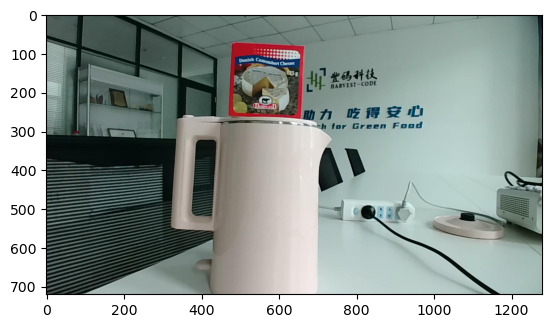

In [5]:
idx_num = 3
cat_idx = 3
fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
img_fname = fname + '.jpg'
calib_fname = fname + '.txt'
imgL_bgr = cv2.imread(data_folder_left + img_fname)
imgR_bgr = cv2.imread(data_folder_right + img_fname)
# cv2 和 plt 读取图像时每个像素的格式是不一样的，前者是[B,G,R]，后者是[R,G,B]
b1,g1,r1 = cv2.split(imgL_bgr)
imgL_color = cv2.merge((r1,g1,b1))
b2,g2,r2 = cv2.split(imgL_bgr)
imgR_color = cv2.merge((r2,g2,b2))

# check the size of both images, resize it if necessary
print(imgL_color.shape, imgR_color.shape)
plt.imshow(imgL_color)

In [6]:
imgL_bw = cv2.blur(cv2.cvtColor(imgL_bgr, cv2.COLOR_RGB2GRAY),(5,5))
imgR_bw = cv2.blur(cv2.cvtColor(imgR_bgr, cv2.COLOR_RGB2GRAY),(5,5))
print(imgL_bw.shape, imgR_bw.shape)

(720, 1280) (720, 1280)


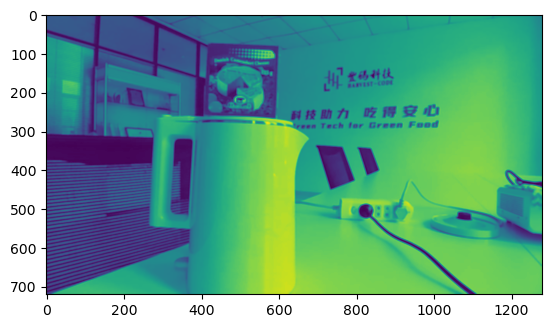

In [7]:
#plt.imshow(img_right_bw, cmap='gray')

plt.imshow(imgR_bw)

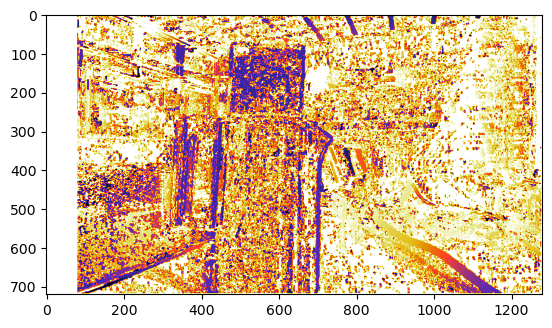

In [53]:
stereo = cv2.StereoBM_create(numDisparities=80, blockSize=5)
disparity = stereo.compute(imgL_bw,imgR_bw)

img = disparity.copy()
plt.imshow(img, 'CMRmap_r')

In [54]:
# Reading calibration
matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_fname = 'IMG_0001.txt'
calib_file = data_folder_calib + calib_fname
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)

# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3
Tmat = np.array([0.54, 0., 0.])
rev_proj_matrix = np.zeros((4,4))
cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = imgL_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);
print(calib_matrix_1)
print(calib_matrix_2)

[[668.14667   0.      594.85803]
 [  0.      671.1518  358.6677 ]
 [  0.        0.        1.     ]]
[[670.1619    0.      651.3274 ]
 [  0.      673.33026 347.52475]
 [  0.        0.        1.     ]]


In [55]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

/var/folders/cx/8ng4ntt5617b85zspl39xd340000gn/T/ipykernel_39962/4192418918.py:6: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


out.ply saved


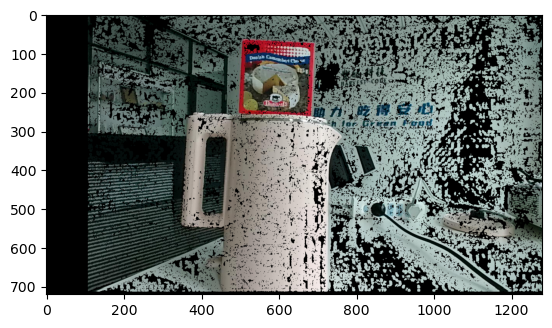

In [56]:
reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)


blank_img = np.zeros(imgL_color.shape, 'uint8')
img_colors = imgR_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)
showImg(blank_img)